# What are the numerical effects of `adapt_object_mesh`?

## Abstract

Additional iterations of `adapt_object_mesh` are positively correlated with improved smoothness by a reciprocal function. However, it also causes a small, linear increase in volume — an undesirable side-effect.

## Introduction

`adapt_object_mesh` is a function from CIVET which implements Taubin smoothing of polygonal meshes. Its typical usage is

```shell
adapt_object_mesh surf.obj smoothed.obj 0 {n_iterations} 0 0
```

Where `n_iterations` is the parameter for "number of post-adaptation smoothing iterations".

The purpose of this analysis is to numerically quantify the geometric effects of the `n_iterations` parameter of `adapt_object_mesh` on standard (81,920 triangle) polygonal meshes.

## Method

The containing directory is a [Datalad](https://datalad.org) repository containing the data read by this Jupyter notebook. Full details are given by the command `git log`. A brief description of the data creation:

1. A surface of a sphere with a radius of 25 units was created.
2. We ran `surface_fit` using a large Laplacian weight to make the smoothness worse.
3. We ran `adapt_object_mesh` with varying number of smoothing iterations \[0, 1000]

Surfaces were evaluated using:

- [`pl-smoothness-error`](https://github.com/FNNDSC/pl-smoothness-error) "smoothness error": average difference in mean curvature between each vertex and its neighbors
- [`pl-pyvista-volume`](https://github.com/FNNDSC/pl-pyvista-volume) "volume": volume enclosed by the mesh

## Results

Non-linear regression between `adapt_object_mesh` smoothing iterations ($I$) and mean smoothness error ($\overline{E}$), $r^2$=0.9996:

$$ \overline{E}(I)=\frac{10.937}{I+14.531}+0.020$$

The slope between iterations of smoothing and volume was +0.60744, $r^2$=1.000.
Note that the starting volume was 71784.749.

## Conclusion

`adapt_object_mesh` improves smoothness, however there are diminishing returns on the improvement.
It has a small side effect of increasing volume.

The inverse function of $\overline{E}(I)$ can be used to minimize the parameter value for `adapt_object_mesh` when trying to achieve a specified target mean smoothness error, $E_T$:

$$ \text{predicted } I(E_T)=\frac{10.937}{E_T-0.020}-14.531 $$

The function $\text{predicted } I(E_T)$'s domain is constrained by the curve's asymptotes:

$$ 0.020 < E_T < \overline{E}(0) $$

Given a surface with a mean smoothness error $E_0$: the minimum parameter value for `adapt_object_mesh` ($P$) which is predicted to be able to improve mean smoothness to $E_T$ where $E_T<E_0$ is

$$ \text{predicted } P(E_0,E_T) = I(E_T) - I(E_0) $$


## Code

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

import os
from pathlib import Path

### Load Data

In [ ]:
data_dir = Path(os.getcwd()).parent / '4_adapt_object_mesh'
assert data_dir.is_dir()
data_files = list(data_dir.glob('*.smtherr.txt'))
assert len(data_files) > 1

In [3]:
def sibling(p: Path, measure: str) -> Path:
    glob = p.parent.glob(f'{p.name.split(".")[0]}.{measure}.txt')
    return next(glob)


def read_volume_for(p: Path) -> float:
    fname = sibling(p, 'volume')
    data = fname.read_text()
    return float(data)


def parse_iter_smooth(p: Path) -> int:
    return int(p.name.split('_')[2])


def load_file(t: tuple[int, Path]) -> pd.DataFrame:
    i, p = t
    data = np.loadtxt(p, dtype=np.float32)

    if len(data) != 40962:
        raise ValueError(f'{p} contains wrong amount of data, {len(data)} != 40962')

    return pd.DataFrame({
        'iter_smooth': parse_iter_smooth(p),
        'mean_smtherr': data.mean(),
        'volume': read_volume_for(p)
    }, index=[i])


with tqdm(data_files) as pbar:
    df = pd.concat(map(load_file, enumerate(pbar)))

df.sort_values(by='iter_smooth', inplace=True)
df.reset_index(drop=True, inplace=True)

### Helper Functions

In [4]:
def linear_regression(df: pd.DataFrame):
    x = np.array(df['iter_smooth'], dtype=np.float32)
    y = np.array(df['volume'], dtype=np.float32)
    A = np.vstack([x, np.ones(len(x))]).T

    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    pred = x * m + c
    r2 = r2_score(y, pred)
    print(f'y = {m:.4E}*x + {c:.4f}, r^2={r2:.4f}')

### Linear Increase in

Ordinary least-squares regression analysis

In [5]:
df.volume.min(), df.volume.max()

(71784.7492231343, 72395.273776247)

In [ ]:
linear_regression(df)

y = 6.0744E-01*x + 71787.2927, r^2=1.0000


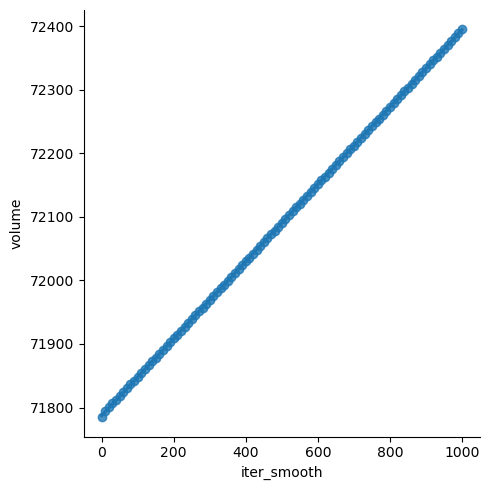

In [ ]:
sns.lmplot(df, x='iter_smooth', y='volume')

### Non-linear Decrease in Smoothness Error

Non-linear least-squares regression analysis

<AxesSubplot: xlabel='iter_smooth', ylabel='mean_smtherr'>

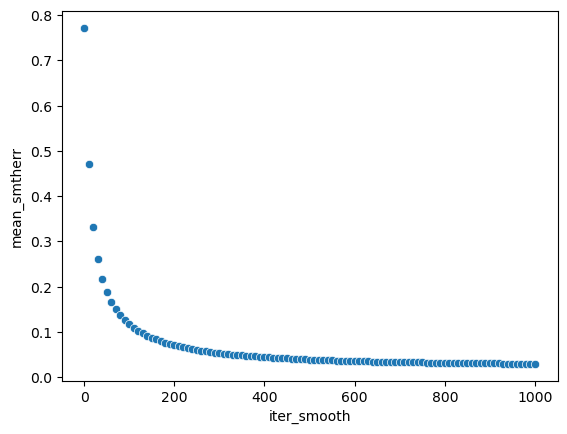

In [ ]:
sns.scatterplot(df, x='iter_smooth', y='mean_smtherr')

In [ ]:
def reciprocal_func(x, a, h, k):
    return a / (x - h) + k

Workaround: for model fitting we only consider the data points for less than 300 iterations. We include fewer data points to convince `curve_fit` that the steep part of the curve are not outliers.

In [ ]:
df_left = df[df.iter_smooth < 300]

In [ ]:
popt, pconv = curve_fit(reciprocal_func, df_left.iter_smooth, df_left.mean_smtherr)


def predicted_func(x):
    return reciprocal_func(x, *popt)

prediction = df.iter_smooth.map(predicted_func)
r2 = r2_score(df.mean_smtherr, prediction)
r2

0.9996121100213473

In [ ]:
popt

array([ 10.93738233, -14.53134114,   0.01999569])

<AxesSubplot: xlabel='iter_smooth', ylabel='mean_smtherr'>

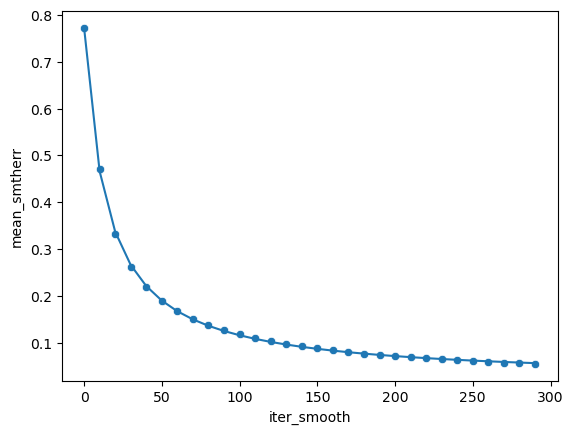

In [ ]:
ax = sns.scatterplot(df_left, x='iter_smooth', y='mean_smtherr')
sns.lineplot(x=df_left.iter_smooth, y=prediction, ax=ax)